In [1]:
import torch
import numpy as np
from torch.autograd import grad as Grad
import matplotlib.pyplot as plt
from torch import Tensor
from typing import Callable
import time
from tqdm import tqdm

Settings

In [2]:
torch.manual_seed(19)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Cpu here

mu = torch.tensor([0, 3.5], device=device)
dim = mu.shape[0]
cov = torch.eye(dim, device=device)

a = 0.5 
b = 2.0 

ITERATIONS = int(5e5) # I'm unavailable to the GPU in my group so I have to reduce the sample size otherwise my computer would not work.
BURN_IN = int(4e5)

Rejection function

In [3]:
def rejection(N, a, b):
    samples = []

    while len(samples) < N:
        proposal = np.random.normal(loc=(0, 3.5), size=(100000, 2))
        dists = ((proposal[:, 0] ** 2) / a**2) + ((proposal[:, 1] ** 2) / b**2)
        accepted = proposal[dists <= 1.0]
        samples.extend(accepted.tolist())

    return np.array(samples[:N])

Proj. LMC functions

In [4]:
def projlmc_step(x: Tensor, grad_f: Callable[[Tensor], Tensor], proj: Callable[[Tensor], Tensor], step_size: float) -> Tensor:
    grad = grad_f(x).detach()
    noise = torch.randn_like(x)
    x = x - step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise
    x = proj(x)
    return x

def projlmc_run_chain(
    f: Callable[[Tensor], Tensor],
    proj: Callable[[Tensor], Tensor],
    k: int,
    burnin: int, #I add this in case this code need to be run under the scheme where burnin != 0
    proj_steps: int,
    step_size: float,
    initial_point: Tensor
) -> Tensor:
    
    x = initial_point.clone()

    def grad_f(x):
        x = x.detach().requires_grad_(True)
        fx = f(x)
        grad = Grad(fx, x)[0]
        return grad

    all_samples = []
    
    for k in tqdm(range(k), desc='Proj time:'):
        samples = []
        for i in range(burnin+proj_steps):
            x = projlmc_step(x, grad_f, proj, step_size)
            samples.append(x.clone())
            
        samples = samples[burnin:] 
        all_samples.append(samples[-1].clone())

    return torch.stack(all_samples)

PD-LMC functions

In [5]:
def langevin_step(x: Tensor, grad_u: Callable[[Tensor], Tensor], proj: Callable[[Tensor], Tensor], step_size: float) -> Tensor:
    noise = torch.randn_like(x)
    grad = grad_u(x).detach()
    x = x - step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise
    return proj(x)

In [6]:
def pdlmc_sample_chain(
    f: Callable[[Tensor], Tensor],
    g: Callable[[Tensor], Tensor],
    h: Callable[[Tensor], Tensor],
    iterations: int,
    lmc_steps: int,
    burnin: int,
    step_size_x: float,
    step_size_lmbda: float,
    step_size_nu: float,
    initial_x: Tensor,
    initial_lmbda: Tensor,
    initial_nu: Tensor,
    proj: Callable[[Tensor], Tensor] = lambda x: x,
) -> Tensor:
    
    x = initial_x.clone()
    lmbda = initial_lmbda.clone()
    nu = initial_nu.clone()
    
    def grad_u(x):
        x = x.detach().requires_grad_(True)
        U = f(x) + torch.dot(lmbda, g(x)) + torch.dot(nu, h(x))
        grad_x = Grad(U, x, create_graph=False)[0]
        return grad_x
    
    all_samples = []

    for i in tqdm(range(iterations), desc='PD time:'):
        samples = []
        for ii in range(lmc_steps + burnin):
            x = langevin_step(x, grad_u, proj, step_size_x)
            samples.append(x.clone())

        samples = samples[burnin:] 
        all_samples.append(samples[-1].clone())
        
        qlmbda = 0.
        qnu = 0.
        total = 0
        for sam in samples:
            total += 1
            qlmbda += g(sam)
            qnu = h(sam)
        qlmbda /= total
        qnu /= total

        lmbda = torch.relu(lmbda + step_size_lmbda * qlmbda)
        nu = nu + step_size_nu * qnu

    return torch.stack(all_samples)

Objective and constraints

In [7]:
f = lambda x: 0.5 * torch.sum((x - mu)**2)

g = lambda x: torch.clamp((x[0] / 0.5) ** 2 + (x[1] / 2.0) ** 2 - 1., min=0.0).reshape([1])

h = lambda x: torch.zeros_like(x)

proj = lambda x: x / torch.maximum(
    torch.sqrt((x[0] / 0.5) ** 2 + (x[1] / 2.0) ** 2), 
    torch.tensor(1.0, device=x.device)
)

Sampling and report the time

In [8]:
start = time.time()
samples_re = rejection(BURN_IN, a, b)
print(f"Rejection sampling finished processing in {time.time()-start} seconds.")

start = time.time()
samples_proj = projlmc_run_chain(f=f, proj=proj, k=ITERATIONS, burnin=0, proj_steps=1, step_size=1e-3, initial_point=torch.tensor([0., 0.])).numpy()
print(f"Proj-LMC finished processing in {time.time()-start} seconds.")

start = time.time()
samples_pd = pdlmc_sample_chain(
    f=f,
    g=g,
    h=h,
    iterations=ITERATIONS,
    lmc_steps=1,
    burnin=0,
    step_size_x=1e-3,
    step_size_lmbda=2e-1,
    step_size_nu=0,
    initial_x=torch.zeros(2),
    initial_lmbda=torch.zeros(1),
    initial_nu=torch.zeros(2),
).numpy()
print(f"PD-LMC finished processing in {time.time()-start} seconds.")

Rejection sampling finished processing in 1.576047420501709 seconds.


Proj time:: 100%|██████████| 500000/500000 [00:44<00:00, 11113.35it/s]


Proj-LMC finished processing in 45.26534819602966 seconds.


PD time:: 100%|██████████| 500000/500000 [01:51<00:00, 4473.71it/s]


PD-LMC finished processing in 112.04550886154175 seconds.


Parameter selection according to mean estimation

In [9]:
best_dist = 999
best_sample_pd = None
true_mean = samples_re.mean(axis=0)
best_para = None
for step_size_x in [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]:
    for step_size_lmbda in [4e-1, 2e-1, 1e-1, 5e-2, 1e-2]:
        samples_pd = pdlmc_sample_chain(
            f=f,
            g=g,
            h=h,
            iterations=ITERATIONS,
            lmc_steps=1,
            burnin=0,
            step_size_x=step_size_x,
            step_size_lmbda=step_size_lmbda,
            step_size_nu=0,
            initial_x=torch.zeros(2),
            initial_lmbda=torch.zeros(1),
            initial_nu=torch.zeros(2),
        ).numpy()
        est_mean_pd = samples_pd.mean(axis=0)
        dist = np.linalg.norm(true_mean-est_mean_pd)
        if dist <= best_dist:
            best_dist = dist
            best_sample_pd = samples_pd
            best_para = [step_size_x, step_size_lmbda]

print(f'Best step size of x: {best_para[0]}.')
print(f'Best step size of lambda: {best_para[1]}.')
samples_pd = best_sample_pd

PD time:: 100%|██████████| 500000/500000 [01:58<00:00, 4209.69it/s]


Best step size of x: 0.0005.
Best step size of lambda: 0.1.


Report the mean and out-of-the-ellipsoid rate

In [10]:
true_mean = samples_re.mean(axis=0)
est_mean_proj = samples_proj.mean(axis=0)
est_mean_pd = samples_pd.mean(axis=0)
print(f'The true mean: {true_mean[0]:.4f}, {true_mean[1]:.4f}')
print(f'The estimation mean of Proj-LMC: {est_mean_proj[0]:.4f}, {est_mean_proj[1]:.4f}')
print(f'The estimation mean of PD-LMC: {est_mean_pd[0]:.4f}, {est_mean_pd[1]:.4f}')

frac_outside = (((samples_pd[:,0]/a)**2 + (samples_pd[:,1]/b)**2) > 1).mean()
frac_pd = (((samples_pd[:,0]/a)**2 + (samples_pd[:,1]/b)**2) >= 1-1e-3).mean()
frac_proj = (((samples_proj[:,0]/a)**2 + (samples_proj[:,1]/b)**2) >= 1-1e-3).mean()
print(f'PD-LMC fraction out of ellipsoid: {frac_outside: .4f}')
print(f'PD-LMC fraction on the ellipsoid: {frac_pd-frac_outside: .4f}') 
print(f'Proj-LMC fraction on the ellipsoid: {frac_proj: .4f}')

The true mean: 0.0001, 1.4156
The estimation mean of Proj-LMC: 0.0002, 0.7415
The estimation mean of PD-LMC: 0.0030, 1.4137
PD-LMC fraction out of ellipsoid:  0.0416
PD-LMC fraction on the ellipsoid:  0.0009
Proj-LMC fraction on the ellipsoid:  0.0759


Plot

C:\Users\DELL\AppData\Local\Temp\ipykernel_21116\36393591.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('./samples.png')


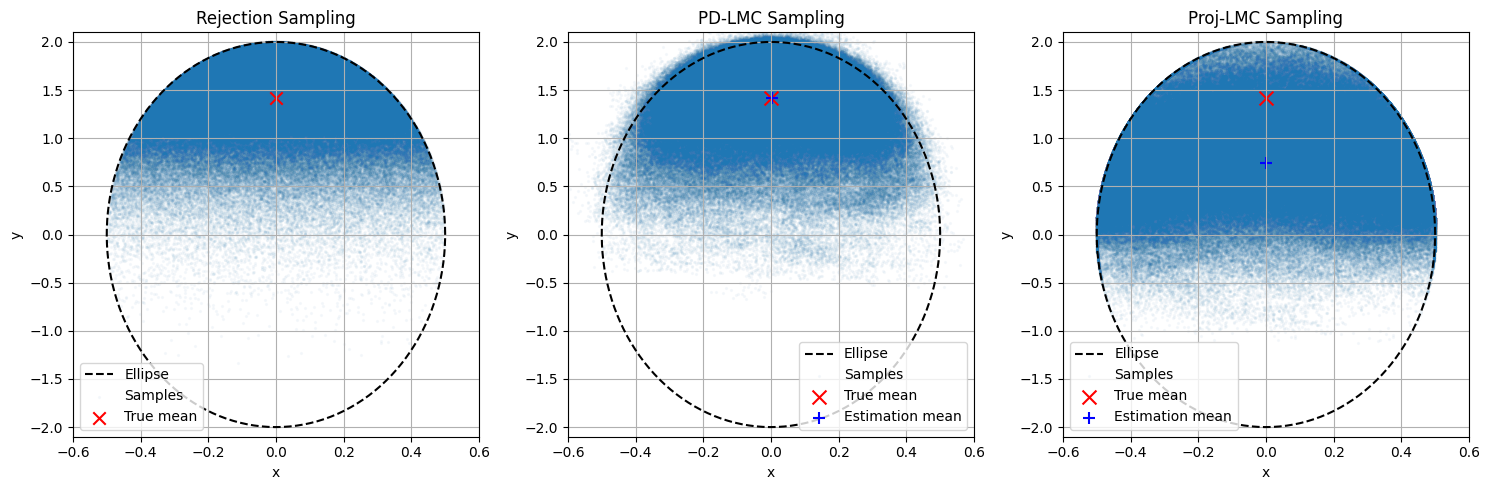

In [12]:
theta = np.linspace(0, 2 * np.pi, 300)
ellipse_x = a * np.cos(theta)
ellipse_y = b * np.sin(theta)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(ellipse_x, ellipse_y, 'k--', label=f'Ellipse')
plt.scatter(samples_re[:, 0], samples_re[:, 1], s=2, alpha=0.03, label='Samples')
plt.scatter(true_mean[0], true_mean[1], color='red', s=80, marker='x', label='True mean')
plt.xlim([-0.6, 0.6])
plt.ylim([-2.1, 2.1])
plt.xlabel('x')
plt.ylabel('y')
plt.title("Rejection Sampling")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(ellipse_x, ellipse_y, 'k--', label=f'Ellipse')
plt.scatter(samples_pd[:, 0], samples_pd[:, 1], s=2, alpha=0.03, label='Samples')
plt.scatter(true_mean[0], true_mean[1], color='red', s=100, marker='x', label='True mean')
plt.scatter(est_mean_pd[0], est_mean_pd[1], color='blue', s=80, marker='+', label='Estimation mean')
plt.xlim([-0.6, 0.6])
plt.ylim([-2.1, 2.1])
plt.xlabel('x')
plt.ylabel('y')
plt.title("PD-LMC Sampling")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ellipse_x, ellipse_y, 'k--', label=f'Ellipse')
plt.scatter(samples_proj[:, 0], samples_proj[:, 1], s=2, alpha=0.03, label='Samples')
plt.scatter(true_mean[0], true_mean[1], color='red', s=100, marker='x', label='True mean')
plt.scatter(est_mean_proj[0], est_mean_proj[1], color='blue', s=80, marker='+', label='Estimation mean')
plt.xlim([-0.6, 0.6])
plt.ylim([-2.1, 2.1])
plt.xlabel('x')
plt.ylabel('y')
plt.title("Proj-LMC Sampling")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('./samples.png')
plt.show()